In [16]:
# Install required packages
import subprocess
import sys

# Install geemap if not installed
try:
    import geemap
    print("geemap already installed")
except ImportError:
    print("Installing geemap...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "geemap", "-q"])
    import geemap
    print("geemap installed successfully")

# Install earthengine-api if not installed
try:
    import ee
    print("earthengine-api already installed")
except ImportError:
    print("Installing earthengine-api...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "earthengine-api", "-q"])
    import ee
    print("earthengine-api installed successfully")

geemap already installed
earthengine-api already installed


In [17]:
# Authenticate and Initialize Google Earth Engine
import ee
import geemap

# Initialize with project ID
try:
    ee.Initialize(project='mythical-sweep-471412-h5')
    print("GEE initialized successfully!")
except Exception as e:
    print("Authenticating with Google Earth Engine...")
    ee.Authenticate()
    ee.Initialize(project='mythical-sweep-471412-h5')
    print("GEE authenticated and initialized successfully!")

GEE initialized successfully!


In [18]:
# Load CerealDataAmir shapefile
import geopandas as gpd
import pandas as pd
import numpy as np
from pathlib import Path

# Define paths
BASE_DIR = Path('/home/crop/Desktop/crop2')
CEREAL_AMIR_DIR = BASE_DIR / 'CerealDataAmir' / 'CerealData'
CEREAL_AMIR_OUTPUT_DIR = BASE_DIR / 'output' / 'cereal_amir_data'
CEREAL_AMIR_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Load the cereal shapefile
cereal_amir = gpd.read_file(CEREAL_AMIR_DIR / 'cerealPoly_export.shp')

# Add class label (all are cereal)
cereal_amir['class'] = 1  # cereal
cereal_amir['split'] = 'validation'  # all validation

# Add unique ID
cereal_amir['patch_id'] = range(len(cereal_amir))

print(f"CerealDataAmir samples: {len(cereal_amir)}")
print(f"  - All cereal class (validation only)")
print(f"\nBounds: {cereal_amir.total_bounds}")
print(f"CRS: {cereal_amir.crs}")
print(f"\nColumns: {list(cereal_amir.columns)}")

CerealDataAmir samples: 1
  - All cereal class (validation only)

Bounds: [ 5.2699491  36.14257193  5.47736751 36.29379295]
CRS: EPSG:4326

Columns: ['geometry', 'class', 'split', 'patch_id']


In [19]:
# Define extraction parameters
START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

# Bands to extract (matching PASTIS format)
S2_BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']

# Patch size and resolution
PATCH_SIZE = 128
RESOLUTION = 10

print(f"Extraction Parameters:")
print(f"  - Date Range: {START_DATE} to {END_DATE}")
print(f"  - Bands: {S2_BANDS}")
print(f"  - Patch Size: {PATCH_SIZE}x{PATCH_SIZE} pixels")
print(f"  - Resolution: {RESOLUTION}m")
print(f"  - Spatial extent: {PATCH_SIZE * RESOLUTION / 1000:.2f}km x {PATCH_SIZE * RESOLUTION / 1000:.2f}km per patch")

Extraction Parameters:
  - Date Range: 2023-01-01 to 2023-04-30
  - Bands: ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
  - Patch Size: 128x128 pixels
  - Resolution: 10m
  - Spatial extent: 1.28km x 1.28km per patch


In [20]:
# Functions to create 128x128 patches from polygons
def get_patch_bounds(centroid_x, centroid_y, patch_size=128, resolution=10):
    """Calculate patch bounds centered on a point"""
    half_extent = (patch_size * resolution) / 2  # meters
    # Convert degrees to meters (approximate for Algeria ~35°N)
    deg_per_meter_lon = 1 / (111320 * np.cos(np.radians(centroid_y)))
    deg_per_meter_lat = 1 / 110540
    
    half_extent_lon = half_extent * deg_per_meter_lon
    half_extent_lat = half_extent * deg_per_meter_lat
    
    return [
        centroid_x - half_extent_lon,  # min_x
        centroid_y - half_extent_lat,  # min_y
        centroid_x + half_extent_lon,  # max_x
        centroid_y + half_extent_lat   # max_y
    ]

def split_large_polygon(geometry, patch_size=128, resolution=10):
    """Split a large polygon into multiple 128x128 patches"""
    from shapely.geometry import box
    
    bounds = geometry.bounds  # minx, miny, maxx, maxy
    centroid = geometry.centroid
    
    # Calculate polygon extent in meters
    extent_x_m = (bounds[2] - bounds[0]) * 111320 * np.cos(np.radians(centroid.y))
    extent_y_m = (bounds[3] - bounds[1]) * 110540
    
    patch_extent_m = patch_size * resolution  # 1280m for 128x128 at 10m
    
    # If polygon fits in one patch, return single centered patch
    if extent_x_m <= patch_extent_m and extent_y_m <= patch_extent_m:
        return [get_patch_bounds(centroid.x, centroid.y, patch_size, resolution)]
    
    # Otherwise, create grid of patches covering the polygon
    patches = []
    
    # Number of patches needed in each direction
    n_patches_x = int(np.ceil(extent_x_m / patch_extent_m))
    n_patches_y = int(np.ceil(extent_y_m / patch_extent_m))
    
    # Calculate step size in degrees
    deg_per_meter_lon = 1 / (111320 * np.cos(np.radians(centroid.y)))
    deg_per_meter_lat = 1 / 110540
    step_lon = patch_extent_m * deg_per_meter_lon
    step_lat = patch_extent_m * deg_per_meter_lat
    
    # Start from bottom-left of bounding box
    start_x = bounds[0] + step_lon / 2
    start_y = bounds[1] + step_lat / 2
    
    for i in range(n_patches_x):
        for j in range(n_patches_y):
            patch_center_x = start_x + i * step_lon
            patch_center_y = start_y + j * step_lat
            
            # Check if patch center is within or near the polygon
            patch_bounds = get_patch_bounds(patch_center_x, patch_center_y, patch_size, resolution)
            patch_box = box(patch_bounds[0], patch_bounds[1], patch_bounds[2], patch_bounds[3])
            
            if geometry.intersects(patch_box):
                patches.append(patch_bounds)
    
    return patches

print("Patch creation functions defined!")

Patch creation functions defined!


In [21]:
# Create patches from CerealDataAmir samples
cereal_amir_patches = []

for idx, row in cereal_amir.iterrows():
    patches = split_large_polygon(row.geometry)
    for p_idx, patch_bounds in enumerate(patches):
        cereal_amir_patches.append({
            'original_id': row['patch_id'],
            'patch_idx': p_idx,
            'class': row['class'],
            'split': row['split'],
            'bounds': patch_bounds,
            'center_lon': (patch_bounds[0] + patch_bounds[2]) / 2,
            'center_lat': (patch_bounds[1] + patch_bounds[3]) / 2
        })

cereal_amir_patches_df = pd.DataFrame(cereal_amir_patches)
cereal_amir_patches_df['unique_id'] = range(len(cereal_amir_patches_df))

print(f"Total CerealDataAmir patches to extract: {len(cereal_amir_patches_df)}")
print(f"  - All cereal class: {len(cereal_amir_patches_df)}")
print(f"  - All validation split: {len(cereal_amir_patches_df)}")
print(f"\nPatches per field:")
print(f"  - Min: {cereal_amir_patches_df.groupby('original_id').size().min()}")
print(f"  - Max: {cereal_amir_patches_df.groupby('original_id').size().max()}")
print(f"  - Mean: {cereal_amir_patches_df.groupby('original_id').size().mean():.2f}")

Total CerealDataAmir patches to extract: 39
  - All cereal class: 39
  - All validation split: 39

Patches per field:
  - Min: 39
  - Max: 39
  - Mean: 39.00


In [22]:
# Download function for Sentinel-2 patches
import requests
from io import BytesIO

def download_patch(bounds, start_date, end_date, bands, resolution=10, patch_size=128):
    """
    Download a single patch from GEE as numpy array.
    Returns array of shape (bands, height, width) matching PASTIS format.
    """
    try:
        # Create region geometry
        region = ee.Geometry.Rectangle(bounds)
        
        # Load Sentinel-2 SR collection with cloud filtering
        s2_sr = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
            .filterBounds(region) \
            .filterDate(start_date, end_date) \
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
        
        # Cloud masking function
        def mask_clouds(image):
            scl = image.select('SCL')
            mask = scl.eq(4).Or(scl.eq(5)).Or(scl.eq(6)).Or(scl.eq(2))  # veg, soil, water, dark
            return image.updateMask(mask)
        
        # Compute median composite
        s2_masked = s2_sr.map(mask_clouds)
        composite = s2_masked.select(bands).median()
        
        # Get download URL
        url = composite.getDownloadURL({
            'bands': bands,
            'region': region,
            'scale': resolution,
            'format': 'NPY'
        })
        
        # Download data
        response = requests.get(url, timeout=60)
        if response.status_code != 200:
            return None, f"HTTP {response.status_code}"
        
        # Load numpy array
        data = np.load(BytesIO(response.content))
        
        # Handle structured array (from GEE NPY format)
        if data.dtype.names is not None:
            # Convert structured array to regular array
            arrays = [data[name] for name in data.dtype.names]
            data = np.stack(arrays, axis=0)
        elif len(data.shape) == 3 and data.shape[2] == len(bands):
            # Transpose from (H, W, C) to (C, H, W)
            data = np.transpose(data, (2, 0, 1))
        
        # Ensure correct patch size
        n_bands = len(bands)
        result = np.zeros((n_bands, patch_size, patch_size), dtype=np.int16)
        
        h = min(data.shape[1], patch_size)
        w = min(data.shape[2], patch_size)
        
        # Center the data if smaller than patch_size
        start_h = (patch_size - h) // 2
        start_w = (patch_size - w) // 2
        
        result[:, start_h:start_h+h, start_w:start_w+w] = data[:, :h, :w].astype(np.int16)
        
        return result, None
        
    except Exception as e:
        return None, str(e)

print("Download function defined!")

Download function defined!


In [23]:
# Extract all CerealDataAmir patches
from tqdm import tqdm
import time
from datetime import datetime

# Create output directories
CEREAL_AMIR_DATA_DIR = CEREAL_AMIR_OUTPUT_DIR / 'DATA_S2'
CEREAL_AMIR_ANN_DIR = CEREAL_AMIR_OUTPUT_DIR / 'ANNOTATIONS'
CEREAL_AMIR_DATA_DIR.mkdir(exist_ok=True)
CEREAL_AMIR_ANN_DIR.mkdir(exist_ok=True)

# Track results
cereal_amir_successful = []
cereal_amir_failed = []

print(f"Starting extraction of {len(cereal_amir_patches_df)} CerealDataAmir patches...")
print(f"Output directory: {CEREAL_AMIR_OUTPUT_DIR}")
print(f"Time period: {START_DATE} to {END_DATE}")
print("-" * 50)

for idx, row in tqdm(cereal_amir_patches_df.iterrows(), total=len(cereal_amir_patches_df), desc="Downloading patches"):
    patch_id = row['unique_id']
    bounds = row['bounds']
    
    # Download patch
    data, error = download_patch(
        bounds=bounds,
        start_date=START_DATE,
        end_date=END_DATE,
        bands=S2_BANDS,
        resolution=RESOLUTION,
        patch_size=PATCH_SIZE
    )
    
    if data is not None:
        # Save to .npy file (matching PASTIS format)
        data_with_time = data[np.newaxis, :, :, :]  # Add time dimension
        
        filename = f"S2_{patch_id:05d}.npy"
        np.save(CEREAL_AMIR_DATA_DIR / filename, data_with_time)
        
        cereal_amir_successful.append({
            'patch_id': patch_id,
            'original_id': row['original_id'],
            'class': row['class'],
            'split': row['split'],
            'center_lon': row['center_lon'],
            'center_lat': row['center_lat'],
            'filename': filename
        })
    else:
        cereal_amir_failed.append({
            'patch_id': patch_id,
            'error': error
        })
    
    # Small delay to avoid rate limiting
    time.sleep(0.5)

print(f"\n{'='*50}")
print(f"CerealDataAmir extraction complete!")
print(f"  Successful: {len(cereal_amir_successful)}")
print(f"  Failed: {len(cereal_amir_failed)}")

Starting extraction of 39 CerealDataAmir patches...
Output directory: /home/crop/Desktop/crop2/output/cereal_amir_data
Time period: 2023-01-01 to 2023-04-30
--------------------------------------------------



CerealDataAmir extraction complete!
  Successful: 39
  Failed: 0


In [24]:
# Check failure reasons
print(f"\nFailure Analysis:")
print(f"Total failed: {len(cereal_amir_failed)}")

if len(cereal_amir_failed) > 0:
    # Group errors by type
    error_types = {}
    for failure in cereal_amir_failed:
        error = failure['error']
        if error not in error_types:
            error_types[error] = []
        error_types[error].append(failure['patch_id'])
    
    print(f"\nError types:")
    for error, patch_ids in error_types.items():
        print(f"\n  {error}")
        print(f"    Affected patches: {len(patch_ids)}")
        if len(patch_ids) <= 5:
            print(f"    Patch IDs: {patch_ids}")
        else:
            print(f"    Patch IDs (first 5): {patch_ids[:5]}")
    
    # Show first few detailed failures
    print(f"\nFirst 3 failures in detail:")
    for i, failure in enumerate(cereal_amir_failed[:3]):
        print(f"\n  Failure {i+1}:")
        print(f"    Patch ID: {failure['patch_id']}")
        print(f"    Error: {failure['error']}")
        
        # Get the bounds for this patch
        patch_info = cereal_amir_patches_df[cereal_amir_patches_df['unique_id'] == failure['patch_id']].iloc[0]
        print(f"    Bounds: {patch_info['bounds']}")
        print(f"    Center: ({patch_info['center_lon']:.6f}, {patch_info['center_lat']:.6f})")


Failure Analysis:
Total failed: 0


In [25]:
# Save metadata and annotations
import json

# Create metadata DataFrame
cereal_amir_metadata_df = pd.DataFrame(cereal_amir_successful)

# Save as GeoJSON
if len(cereal_amir_successful) > 0:
    cereal_amir_metadata_gdf = gpd.GeoDataFrame(
        cereal_amir_metadata_df,
        geometry=gpd.points_from_xy(cereal_amir_metadata_df['center_lon'], cereal_amir_metadata_df['center_lat']),
        crs='EPSG:4326'
    )
    cereal_amir_metadata_gdf.to_file(CEREAL_AMIR_OUTPUT_DIR / 'metadata.geojson', driver='GeoJSON')
    
    # Save class labels for each patch (ANNOTATIONS)
    for _, row in cereal_amir_metadata_df.iterrows():
        patch_id = row['patch_id']
        class_label = row['class']
        np.save(CEREAL_AMIR_ANN_DIR / f'Labels_{patch_id:05d}.npy', np.array([class_label]))
    
    # Save summary JSON
    summary = {
        'extraction_date': datetime.now().isoformat(),
        'source': 'Sentinel-2 SR Harmonized (GEE)',
        'data_source': 'CerealDataAmir (Supervisor)',
        'time_range': {'start': START_DATE, 'end': END_DATE},
        'bands': S2_BANDS,
        'resolution_m': RESOLUTION,
        'patch_size': PATCH_SIZE,
        'total_patches': len(cereal_amir_successful),
        'classes': {'1': 'cereal'},
        'note': 'All samples are cereal class, validation split only',
        'splits': cereal_amir_metadata_df['split'].value_counts().to_dict(),
        'class_distribution': cereal_amir_metadata_df['class'].value_counts().to_dict()
    }
    
    with open(CEREAL_AMIR_OUTPUT_DIR / 'extraction_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)
    
    print("CerealDataAmir metadata and annotations saved!")
    print(f"\nDataset Summary:")
    print(f"  - Total patches: {len(cereal_amir_successful)}")
    print(f"  - All validation: {len(cereal_amir_metadata_df)}")
    print(f"  - All cereal class: {len(cereal_amir_metadata_df)}")
    print(f"\nFiles saved to: {CEREAL_AMIR_OUTPUT_DIR}")
else:
    print("No successful downloads to save metadata for.")

CerealDataAmir metadata and annotations saved!

Dataset Summary:
  - Total patches: 39
  - All validation: 39
  - All cereal class: 39

Files saved to: /home/crop/Desktop/crop2/output/cereal_amir_data


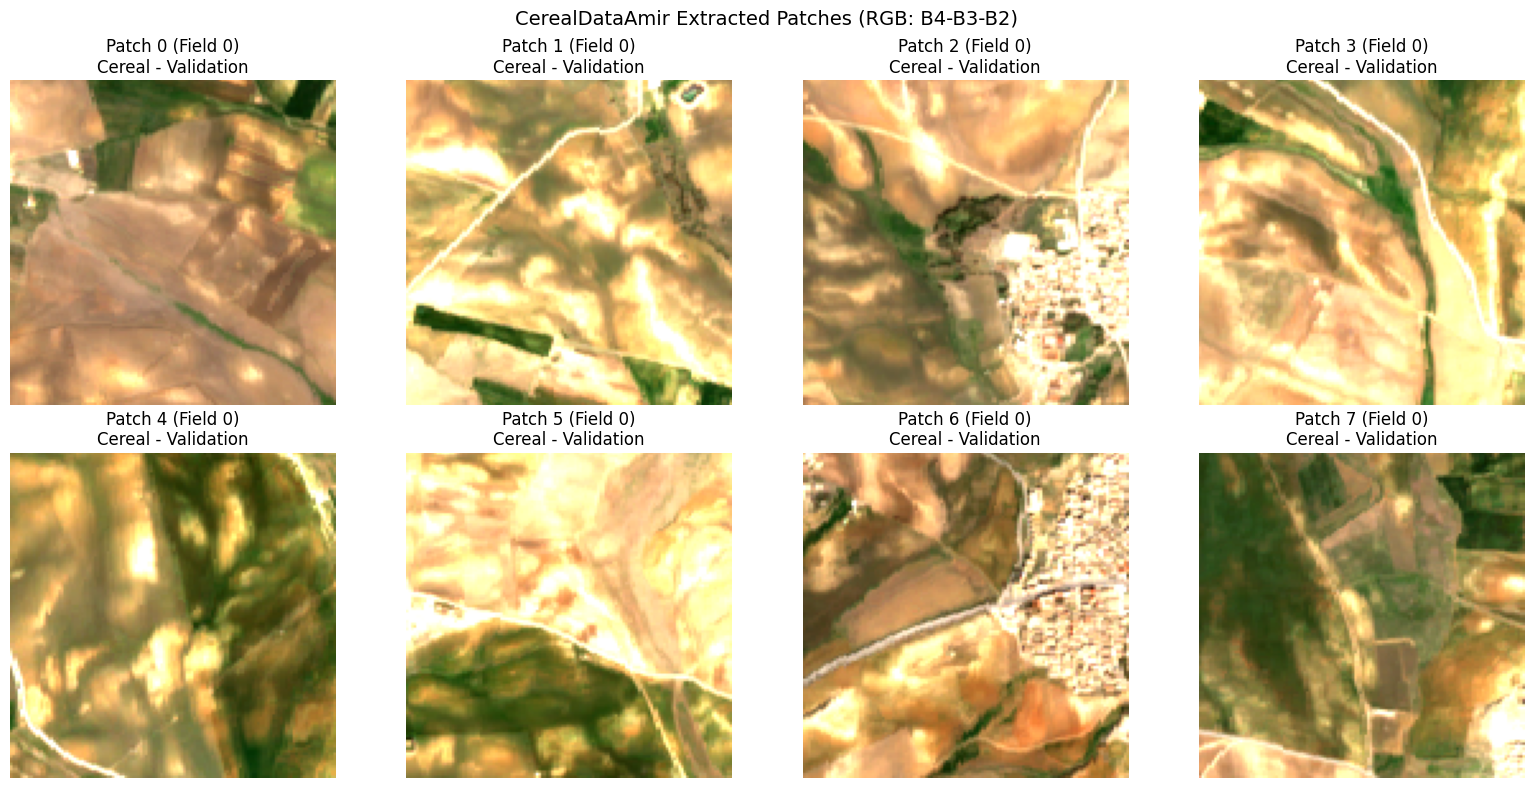


Preview saved to: /home/crop/Desktop/crop2/output/cereal_amir_data/extracted_patches_preview.png


In [26]:
# Visualize extracted patches
import matplotlib.pyplot as plt

if len(cereal_amir_successful) > 0:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for i, row in enumerate(cereal_amir_successful[:8]):
        patch_file = CEREAL_AMIR_DATA_DIR / row['filename']
        data = np.load(patch_file)  # Shape: (1, 10, 128, 128)
        
        # Create RGB composite (B4, B3, B2 = indices 2, 1, 0)
        rgb = data[0, [2, 1, 0], :, :]  # (3, 128, 128)
        rgb = np.transpose(rgb, (1, 2, 0))  # (128, 128, 3)
        
        # Normalize for display
        rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min() + 1e-8)
        rgb = np.clip(rgb * 2.5, 0, 1)  # Brightness adjustment
        
        ax = axes[i]
        ax.imshow(rgb)
        ax.set_title(f"Patch {row['patch_id']} (Field {row['original_id']})\nCereal - Validation")
        ax.axis('off')
    
    # Hide empty subplots
    for i in range(len(cereal_amir_successful[:8]), 8):
        axes[i].axis('off')
    
    plt.suptitle('CerealDataAmir Extracted Patches (RGB: B4-B3-B2)', fontsize=14)
    plt.tight_layout()
    plt.savefig(CEREAL_AMIR_OUTPUT_DIR / 'extracted_patches_preview.png', dpi=150)
    plt.show()
    
    print(f"\nPreview saved to: {CEREAL_AMIR_OUTPUT_DIR / 'extracted_patches_preview.png'}")
else:
    print("No patches to visualize - run extraction first.")